In [1]:
from __future__ import print_function
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf

from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format


In [2]:
! ls

aa.ipynb		 equipment_success.csv	       mlcc-exercises_en.zip
demo.ipynb		 equipment_success_unique.csv
equipment-success.ipynb  mlcc-exercises


In [112]:
equipment_success_dataframe = pd.read_csv("./equipment_success_unique.csv", sep=",")
equipment_success_dataframe.describe()

,patient_id,center_id,months_since_equipped,average_loss,high_loss,low_loss,eq_average_loss,eq_high_loss,eq_low_loss,id,age_in_months_at_equipped_start,rk
count,86176.0,86176.0,86176.0,68510.0,86176.0,86176.0,72789.0,86176.0,86176.0,86176.0,71126.0,86176.0
mean,183134.4,464.7,24.0,56.7,53.5,39.8,34.6,36.9,30.1,650853.6,838.0,1.0
std,61256.1,408.9,30.4,21.0,29.6,28.1,9.5,10.5,11.0,77045.4,219.8,0.0
min,51.0,2.0,0.0,-10.0,-9.2,-10.0,-1.2,-10.0,-10.0,525947.0,0.0,1.0
25%,145368.5,96.0,1.0,42.5,41.4,22.5,28.8,30.0,23.3,586604.0,766.0,1.0
50%,185960.0,312.0,12.0,52.5,56.0,36.7,33.8,35.8,30.0,636870.0,882.0,1.0
75%,228606.0,852.0,37.0,65.0,70.0,53.8,38.8,41.7,35.0,728280.2,974.0,1.0
max,288723.0,1390.0,215.0,125.0,125.0,125.0,120.0,120.0,117.5,778886.0,1559.0,1.0


In [271]:
equipment_success_dataframe

,patient_id,center_id,ears,months_since_equipped,average_loss,high_loss,low_loss,eq_average_loss,eq_high_loss,eq_low_loss,id,age_in_months_at_equipped_start,gender,rk,valid
0,51,14,L,0,nan,70.0,70.0,nan,85.0,85.0,756862,1069.0,NaN,1,False
1,51,14,R,0,nan,55.0,55.0,nan,0.0,70.0,756858,1069.0,NaN,1,False
2,58,199,L,24,32.5,42.5,13.3,31.2,39.2,16.2,565723,1229.0,male,1,False
3,58,199,R,26,nan,45.0,45.0,41.2,43.0,37.5,565730,1229.0,male,1,False
4,496,27,L,46,61.2,70.0,51.7,36.2,38.8,33.3,594098,929.0,NaN,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86171,288699,466,BIN,52,nan,0.0,0.0,31.2,31.0,31.2,617887,965.0,female,1,False
86172,288711,883,BIN,0,41.2,40.0,36.2,26.2,26.0,21.2,639979,883.0,male,1,False
86173,288715,773,BIN,0,nan,0.0,0.0,33.8,38.6,30.0,574112,1097.0,male,1,False
86174,288718,1333,BIN,65,nan,0.0,0.0,37.5,41.0,30.0,743785,611.0,NaN,1,False


In [313]:
equipment_success_dataframe['distance_from_target'] = (-equipment_success_dataframe['eq_average_loss'] + equipment_success_dataframe['average_loss'])/equipment_success_dataframe['average_loss']


In [314]:
equipment_success_dataframe['valid'] = (equipment_success_dataframe['average_loss'].apply(lambda x : not math.isnan(x) and x > 20 and x < 90) & 
                                       equipment_success_dataframe['eq_average_loss'].apply(lambda x : not math.isnan(x)) &
                                       equipment_success_dataframe['high_loss'].apply(lambda x : not math.isnan(x)) &
                                       equipment_success_dataframe['low_loss'].apply(lambda x : not math.isnan(x)) &
                                       equipment_success_dataframe['months_since_equipped'].apply(lambda x : x > 12) &
                                       equipment_success_dataframe['age_in_months_at_equipped_start'].apply(lambda x : not math.isnan(x) and x < 12*90 and x > 12*20))

In [315]:
equipment_success = equipment_success_dataframe.query('valid == True').copy()
equipment_success

,patient_id,center_id,ears,months_since_equipped,average_loss,high_loss,low_loss,eq_average_loss,eq_high_loss,eq_low_loss,id,age_in_months_at_equipped_start,gender,rk,valid,distance_from_target
4,496,27,L,46,61.2,70.0,51.7,36.2,38.8,33.3,594098,929.0,NaN,1,True,0.4
5,496,27,R,21,55.0,68.0,43.3,38.8,33.3,46.7,593790,954.0,NaN,1,True,0.3
10,642,27,L,67,47.5,57.5,31.7,28.8,31.7,21.7,594210,788.0,NaN,1,True,0.4
11,642,27,R,67,48.8,58.8,35.0,28.8,30.0,26.7,593708,788.0,NaN,1,True,0.4
12,660,36,R,41,51.2,61.0,28.8,37.5,43.0,25.0,754597,892.0,NaN,1,True,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86137,288394,1262,BIN,28,30.0,35.7,20.0,20.0,21.0,16.2,673116,678.0,NaN,1,True,0.3
86148,288500,56,R,84,61.2,76.4,41.2,33.8,34.0,35.0,760809,868.0,NaN,1,True,0.4
86153,288536,1295,BIN,28,45.0,47.0,26.2,36.2,37.0,31.2,737590,966.0,NaN,1,True,0.2
86154,288539,1295,R,23,46.2,55.7,41.2,36.2,37.0,33.8,737756,591.0,NaN,1,True,0.2


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f61da8f4f98>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f61da904748>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f61da8c7080>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f61da869978>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f61da894208>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f61da83aac8>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f61da864400>]],
      dtype=object)

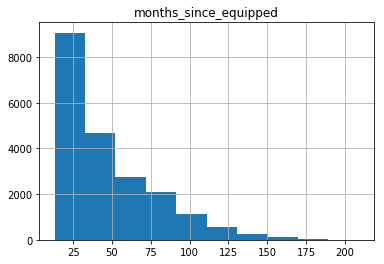

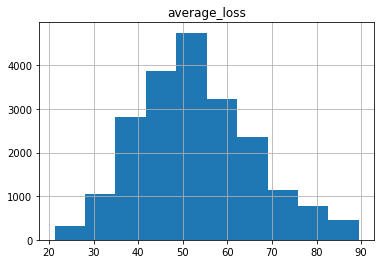

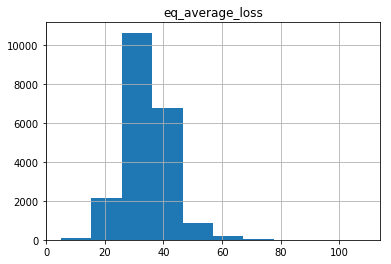

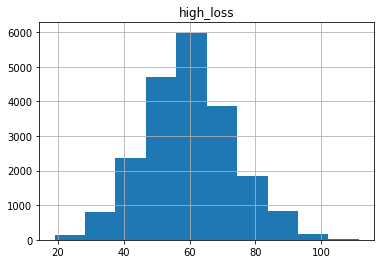

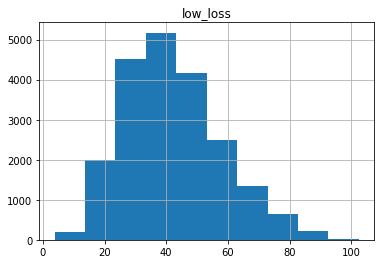

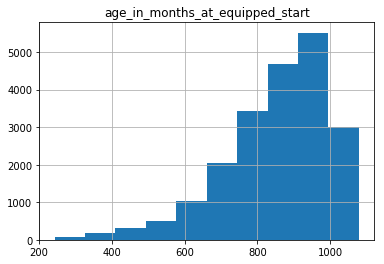

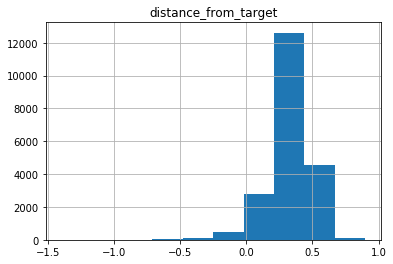

In [316]:
for feature in ['months_since_equipped', 'average_loss', 'eq_average_loss', 'high_loss', 'low_loss', 'age_in_months_at_equipped_start','distance_from_target']:
    display.display(equipment_success.hist(feature))

In [317]:
equipment_success.describe()

,patient_id,center_id,months_since_equipped,average_loss,high_loss,low_loss,eq_average_loss,eq_high_loss,eq_low_loss,id,age_in_months_at_equipped_start,rk,distance_from_target
count,20750.0,20750.0,20750.0,20750.0,20750.0,20750.0,20750.0,20750.0,20750.0,20750.0,20750.0,20750.0,20750.0
mean,168076.4,440.4,47.0,52.8,60.0,42.0,34.2,36.3,30.0,649563.2,854.3,1.0,0.3
std,69314.7,401.0,31.7,13.0,13.5,15.6,7.6,8.3,8.5,78792.5,144.3,0.0,0.2
min,496.0,5.0,13.0,21.2,19.0,3.8,5.0,5.8,-1.2,525957.0,243.0,1.0,-1.4
25%,132725.8,96.0,23.0,43.8,51.0,30.0,29.0,31.0,25.0,582885.5,776.0,1.0,0.3
50%,172595.0,263.0,37.0,51.2,59.3,40.0,33.8,35.8,30.0,635803.0,883.0,1.0,0.3
75%,217958.5,795.0,64.0,61.2,68.6,52.0,38.8,40.8,35.0,732610.8,959.0,1.0,0.4
max,288599.0,1384.0,209.0,89.5,111.4,102.5,108.8,108.8,106.7,778854.0,1079.0,1.0,0.9


In [267]:
def scaleInner(df, feature):
    stats = df[feature].describe();
    std = stats['std']
    mean = stats['mean']
    df[feature + '_scaled'] = (df[feature] - mean)/std
    return df

def scale(df, features):
    scaledDf = df.copy()
    for feature in features:
        scaleInner(scaledDf, feature)
    return scaledDf        

In [382]:
def success_ratio(equipment_success, threshold):
    data = pd.value_counts(equipment_success['eq_average_loss'] < (equipment_success['average_loss']*.5 + threshold))
    return data[True]/(data[False] + data[True])

In [398]:
def model_good_prediction_ratio(targets, predictions, max_distance):
    predictionsDiff = (targets - predictions).apply (lambda x: abs(x))
    return len(list(filter(lambda x: x < max_distance, predictionsDiff)))/len(predictionsDiff)

In [399]:
model_good_prediction_ratio(equipment_success['eq_average_loss'], 34.4, 5)

0.5438554216867469

In [385]:
success_ratio(equipment_success, 0)

0.10289156626506024

In [327]:
(equipment_success['eq_average_loss'] - equipment_success['average_loss']/2).apply(lambda x : abs(x)).describe()          

count   20750.0
mean        8.7
std         5.9
min         0.0
25%         4.4
50%         8.1
75%        11.9
max        85.0
dtype: float64

In [395]:
aa = (equipment_success['eq_average_loss'] - equipment_success['average_loss']/2).apply(lambda x : abs(x))
aa.

In [348]:
(equipment_success['eq_average_loss'] ).describe()['std'] 

7.644759329487

In [364]:
(equipment_success['average_loss'] ).describe()['std'] 

13.020507056187245

In [345]:
(equipment_success['eq_low_loss'] ).describe()['std']

8.52251445808019

In [346]:
(equipment_success['eq_high_loss'] ).describe()['std']

8.335846652749458

In [363]:
mean = (equipment_success['eq_average_loss']).describe()['mean'] 
[mean, math.sqrt((equipment_success['eq_average_loss'] - mean).apply(lambda x : x*x).describe()['mean'])]  

[34.16693975903615, 7.644575116199356]

In [401]:
def preprocess_features(df):
  """Prepares input features from a data set.

  Args:
    df: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = scale(df, ['average_loss', 'high_loss', 'low_loss', 'age_in_months_at_equipped_start'])
  selected_features = selected_features[
    ["age_in_months_at_equipped_start",
     "average_loss",
     "high_loss",
     "low_loss",
     "age_in_months_at_equipped_start_scaled",
     "average_loss_scaled",
     "high_loss_scaled",
     "low_loss_scaled",
    ]]
  processed_features = selected_features


  #processed_features["buck_average_loss"] = bucketized_average_loss
  #processed_features['x1'] = processed_features['average_loss'] * processed_features['high_loss']
  #processed_features['x2'] = processed_features['average_loss'] * processed_features['low_loss']
  #processed_features['x3'] = processed_features['high_loss'] * processed_features['low_loss']
  #processed_features['x4'] = processed_features['average_loss'] * processed_features['months_since_equipped']
  #processed_features['x5'] = processed_features['average_loss'] * processed_features['age_in_months_at_equipped_start']
  #processed_features['x6'] = processed_features['average_loss'] ** 2
  #processed_features['x7'] = processed_features['months_since_equipped'] ** 2
  #processed_features['x8'] = processed_features['age_in_months_at_equipped_start'] ** 2
  
  return processed_features

def preprocess_targets(df):
  """Prepares target features (i.e., labels) from a data set.

  Args:
    df: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  output_targets['eq_average_loss'] = df['eq_average_loss'] 
  #output_targets['distance_from_target'] = ((df['eq_average_loss'] - df['average_loss']/2))
  #output_targets['target_reached'] = (df['eq_average_loss'] < df['average_loss']/2 + 5).astype('float')
    

  #output_targets['distance_from_target'] = ((df['eq_average_loss'] - df['average_loss']/2).apply (lambda x : max(x,0)))

  return output_targets

In [402]:
equipment_success = equipment_success.sample(frac=1)
equipment_success.describe()

,patient_id,center_id,months_since_equipped,average_loss,high_loss,low_loss,eq_average_loss,eq_high_loss,eq_low_loss,id,age_in_months_at_equipped_start,rk,distance_from_target
count,20750.0,20750.0,20750.0,20750.0,20750.0,20750.0,20750.0,20750.0,20750.0,20750.0,20750.0,20750.0,20750.0
mean,168076.4,440.4,47.0,52.8,60.0,42.0,34.2,36.3,30.0,649563.2,854.3,1.0,0.3
std,69314.7,401.0,31.7,13.0,13.5,15.6,7.6,8.3,8.5,78792.5,144.3,0.0,0.2
min,496.0,5.0,13.0,21.2,19.0,3.8,5.0,5.8,-1.2,525957.0,243.0,1.0,-1.4
25%,132725.8,96.0,23.0,43.8,51.0,30.0,29.0,31.0,25.0,582885.5,776.0,1.0,0.3
50%,172595.0,263.0,37.0,51.2,59.3,40.0,33.8,35.8,30.0,635803.0,883.0,1.0,0.3
75%,217958.5,795.0,64.0,61.2,68.6,52.0,38.8,40.8,35.0,732610.8,959.0,1.0,0.4
max,288599.0,1384.0,209.0,89.5,111.4,102.5,108.8,108.8,106.7,778854.0,1079.0,1.0,0.9


In [403]:
total_samples = math.floor(equipment_success.count()['ears'] /3 )
examples = preprocess_features(equipment_success)
targets = preprocess_targets(equipment_success)

training_test_ratio = 0.8
training_samples = math.floor(total_samples*0.8)
validation_samples = total_samples - training_samples

[training_samples, validation_samples]

[5532, 1384]

In [404]:
examples

,age_in_months_at_equipped_start,average_loss,high_loss,low_loss,age_in_months_at_equipped_start_scaled,average_loss_scaled,high_loss_scaled,low_loss_scaled
47063,787.0,76.2,72.0,77.5,-0.5,1.8,0.9,2.3
47940,778.0,47.5,59.0,20.0,-0.5,-0.4,-0.1,-1.4
38164,1015.0,31.2,45.0,16.2,1.1,-1.7,-1.1,-1.7
78689,959.0,88.8,90.7,87.5,0.7,2.8,2.3,2.9
10247,1029.0,56.2,80.0,34.0,1.2,0.3,1.5,-0.5
...,...,...,...,...,...,...,...,...
78889,598.0,37.5,44.0,28.3,-1.8,-1.2,-1.2,-0.9
37052,853.0,45.0,51.7,28.8,-0.0,-0.6,-0.6,-0.9
77965,913.0,42.5,59.3,21.2,0.4,-0.8,-0.1,-1.3
78626,1035.0,55.0,70.7,41.0,1.3,0.2,0.8,-0.1


In [405]:
targets.describe()

,eq_average_loss
count,20750.0
mean,34.2
std,7.6
min,5.0
25%,29.0
50%,33.8
75%,38.8
max,108.8


In [406]:
training_examples = examples.head(training_samples).copy()
training_examples.describe()

,age_in_months_at_equipped_start,average_loss,high_loss,low_loss,age_in_months_at_equipped_start_scaled,average_loss_scaled,high_loss_scaled,low_loss_scaled
count,5532.0,5532.0,5532.0,5532.0,5532.0,5532.0,5532.0,5532.0
mean,855.1,52.7,59.9,42.0,0.0,-0.0,-0.0,-0.0
std,141.2,13.0,13.5,15.6,1.0,1.0,1.0,1.0
min,251.0,22.5,20.7,6.2,-4.2,-2.3,-2.9,-2.3
25%,777.0,43.8,51.0,30.0,-0.5,-0.7,-0.7,-0.8
50%,882.0,51.2,59.8,40.0,0.2,-0.1,-0.0,-0.1
75%,958.0,60.0,68.0,51.7,0.7,0.6,0.6,0.6
max,1079.0,89.5,102.5,101.7,1.6,2.8,3.2,3.8


In [407]:
validation_examples = examples.tail(validation_samples).copy()
validation_examples.describe()

,age_in_months_at_equipped_start,average_loss,high_loss,low_loss,age_in_months_at_equipped_start_scaled,average_loss_scaled,high_loss_scaled,low_loss_scaled
count,1384.0,1384.0,1384.0,1384.0,1384.0,1384.0,1384.0,1384.0
mean,847.0,53.2,60.5,42.1,-0.1,0.0,0.0,0.0
std,146.9,13.1,13.9,15.4,1.0,1.0,1.0,1.0
min,243.0,21.2,22.0,7.5,-4.2,-2.4,-2.8,-2.2
25%,766.8,44.4,51.4,31.2,-0.6,-0.6,-0.6,-0.7
50%,872.0,52.5,60.0,41.0,0.1,-0.0,0.0,-0.1
75%,957.0,61.3,70.0,51.2,0.7,0.7,0.7,0.6
max,1079.0,88.8,107.1,93.8,1.6,2.8,3.5,3.3


In [408]:
training_targets = targets.head(training_samples)

In [409]:
validation_targets = targets.tail(validation_samples)

In [410]:
training_targets.describe()

,eq_average_loss
count,5532.0
mean,34.2
std,7.7
min,5.0
25%,29.5
50%,33.8
75%,38.8
max,103.2


In [411]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of multiple features.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [412]:
def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  deafness_levels = [20, 40, 55, 70, 80, 90]

  #gender = tf.feature_column.categorical_column_with_vocabulary_list('gender', ['male', 'female', 'NaN'])
  age_in_months_at_equipped_start_scaled = tf.feature_column.numeric_column("age_in_months_at_equipped_start_scaled")
  average_loss_scaled = tf.feature_column.numeric_column("average_loss_scaled")
  high_loss_scaled = tf.feature_column.numeric_column("high_loss_scaled")
  low_loss_scaled = tf.feature_column.numeric_column("low_loss_scaled")



  average_loss = tf.feature_column.numeric_column("average_loss")
  bucketized_average_loss = tf.feature_column.bucketized_column(
    average_loss, boundaries=deafness_levels)

  high_loss = tf.feature_column.numeric_column("high_loss")
  bucketized_high_loss = tf.feature_column.bucketized_column(
    high_loss, boundaries=deafness_levels)

  low_loss = tf.feature_column.numeric_column("low_loss")
  bucketized_low_loss = tf.feature_column.bucketized_column(
    low_loss, boundaries=deafness_levels)

  average_x_high_x_low = tf.feature_column.crossed_column(set([bucketized_average_loss, bucketized_high_loss, bucketized_low_loss]), hash_bucket_size=1000) 
  average_x_high = tf.feature_column.crossed_column(set([bucketized_average_loss, bucketized_high_loss]), hash_bucket_size=1000) 
  average_x_low = tf.feature_column.crossed_column(set([bucketized_average_loss, bucketized_low_loss]), hash_bucket_size=1000) 
  return set([average_loss_scaled, high_loss_scaled, low_loss_scaled , age_in_months_at_equipped_start_scaled])
  # return set([average_loss_scaled, high_loss_scaled, low_loss_scaled, average_x_high_x_low, average_x_high, average_x_low, age_in_months_at_equipped_start_scaled])

In [413]:
def train_model(
    model_type,
    learning_rate,
    steps,
    batch_size,
    label,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets,
    hidden_units=[]):
  """Trains a linear regression model of multiple features.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  print('hidden_units: '+ str(hidden_units))
  # Create a linear regressor object.
  #my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate)
 # my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  if model_type == 'linear':
      regressor = tf.estimator.LinearRegressor(
          feature_columns=construct_feature_columns(),
          optimizer=my_optimizer)
  elif model_type == 'neural_net':
      dnn_regressor = tf.estimator.DNNRegressor(
          feature_columns=construct_feature_columns(),
          hidden_units=hidden_units,
          optimizer=my_optimizer)
  else:
    raise Exception('Invalid model type:' + model_type)
  
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets[label], 
      batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets[label], 
      num_epochs=1, 
      shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(
      validation_examples, validation_targets[label], 
      num_epochs=1, 
      shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor, training_predictions, training_targets[label]

In [414]:
def train_linear_classifier_model(
    learning_rate,
    steps,
    batch_size,
    label,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear classification model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearClassifier` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear classifier object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  #my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)  
  linear_classifier = tf.estimator.LinearClassifier(
      feature_columns=construct_feature_columns(),
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets[label], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets[label], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets[label], 
                                                    num_epochs=1, 
                                                    shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("LogLoss (on training data):")
  training_log_losses = []
  validation_log_losses = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.    
    training_probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
    training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
    
    validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
    validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
    
    training_log_loss = metrics.log_loss(training_targets, training_probabilities)
    validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
    # Occasionally print the current loss.
    print("  period %02d : %0.3f" % (period, training_log_loss))
    # Add the loss metrics from this period to our list.
    training_log_losses.append(training_log_loss)
    validation_log_losses.append(validation_log_loss)
  print("Model training finished.")
  
  # Output a graph of loss metrics over periods.
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.tight_layout()
  plt.plot(training_log_losses, label="training")
  plt.plot(validation_log_losses, label="validation")
  plt.legend()

  return linear_classifier

In [205]:
linear_regressor, predictions, targets = train_model(
    learning_rate=5,
    steps=300,
    batch_size=100,
    label='eq_average_loss',
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

TypeError: train_model() missing 1 required positional argument: 'model_type'

hidden_units: [5, 5, 5]
Training model...
RMSE (on training data):
  period 00 : 6.65
  period 01 : 6.66
  period 02 : 6.66
  period 03 : 6.65
  period 04 : 6.65
  period 05 : 6.65
  period 06 : 6.65
  period 07 : 6.65
  period 08 : 6.65
  period 09 : 6.65
Model training finished.


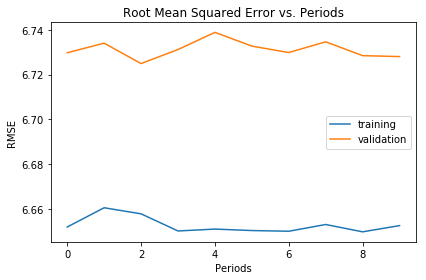

In [421]:
linear_regressor, predictions, targets = train_model(
    model_type='neural_net',
    hidden_units=[5, 5, 5],
    learning_rate=10,
    steps=1000,
    batch_size=200,
    label='eq_average_loss',
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [419]:
[model_good_prediction_ratio(targets, predictions, 5), model_good_prediction_ratio(targets, training_targets.describe()['eq_average_loss']['mean'], 5)]

[0.636117136659436, 0.546999276934201]

In [422]:
[model_good_prediction_ratio(targets, predictions, 5), model_good_prediction_ratio(targets, training_targets.describe()['eq_average_loss']['mean'], 5)]

[0.6366594360086768, 0.546999276934201]

Training model...
LogLoss (on training data):
  period 00 : 0.530
  period 01 : 0.519
  period 02 : 0.518
  period 03 : 0.517
  period 04 : 0.517
  period 05 : 0.517
  period 06 : 0.517
  period 07 : 0.517
  period 08 : 0.517
  period 09 : 0.517
Model training finished.


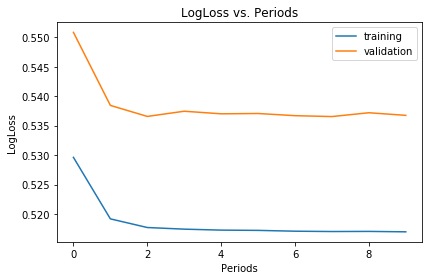

In [293]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.0005,
    steps=600,
    batch_size=200,
    label='target_reached',
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [294]:
predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                  validation_targets["target_reached"], 
                                                  num_epochs=1, 
                                                  shuffle=False)

evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)

print("AUC on the validation set: %0.2f" % evaluation_metrics['auc'])
print("Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy'])
evaluation_metrics

AUC on the validation set: 0.71
Accuracy on the validation set: 0.75


{'accuracy': 0.7485549,
 'accuracy_baseline': 0.7138728,
 'auc': 0.7140829,
 'auc_precision_recall': 0.5333876,
 'average_loss': 0.5367404,
 'global_step': 600,
 'label/mean': 0.28612718,
 'loss': 0.5367404,
 'precision': 0.6090909,
 'prediction/mean': 0.30263147,
 'recall': 0.33838382}

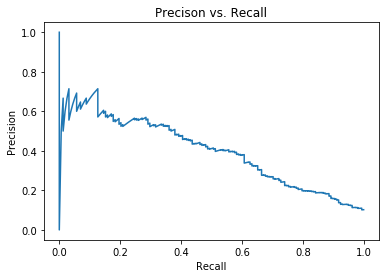

In [213]:
validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
# Get just the probabilities for the positive class.
validation_probabilities = np.array([item['probabilities'][1] for item in validation_probabilities])

precision, recall, thresholds = metrics.precision_recall_curve(
    validation_targets, validation_probabilities)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precison vs. Recall")
_ = plt.show()

In [217]:
validation_probabilities

array([0.06635913, 0.02331385, 0.01645223, ..., 0.15750562, 0.01856546,
       0.07513855], dtype=float32)

In [242]:
validation_targets['target_reached'].values

array([0., 0., 0., ..., 0., 0., 0.])

In [241]:
pd.value_counts(validation_targets['target_reached'])

0.0    1495
1.0     158
Name: target_reached, dtype: int64

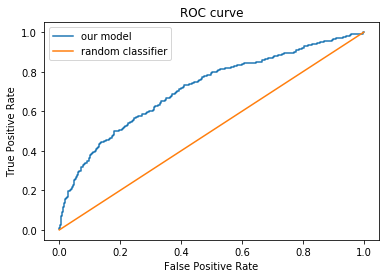

In [295]:
validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
# Get just the probabilities for the positive class.
validation_probabilities = np.array([item['probabilities'][1] for item in validation_probabilities])

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(
    validation_targets, validation_probabilities)
plt.plot(false_positive_rate, true_positive_rate, label="our model")
plt.plot([0, 1], [0, 1], label="random classifier")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC curve")
_ = plt.legend(loc=2)

In [27]:
 predict_training_input_fn = lambda: my_input_fn(
  training_examples, 
  training_targets['eq_average_loss'], 
  num_epochs=1, 
  shuffle=False)
    
training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
training_predictions = np.array([item['predictions'][0] for item in training_predictions])

training_predictions

array([33.161465, 32.640793, 37.437405, ..., 32.65567 , 34.765648,
       33.240456], dtype=float32)

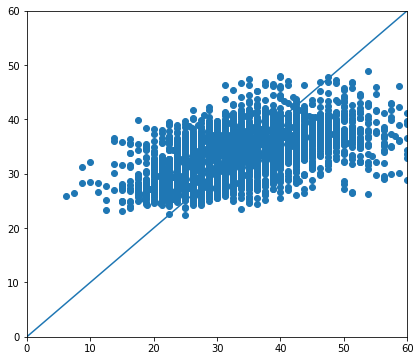

In [685]:
plt.figure(figsize=(15, 6))


plt.subplot(1, 2, 1)
plt.ylim(0, 60)
plt.xlim(0, 60)
plt.plot([0, 60], [0, 60], label="random classifier")

plt.scatter(targets, predictions )

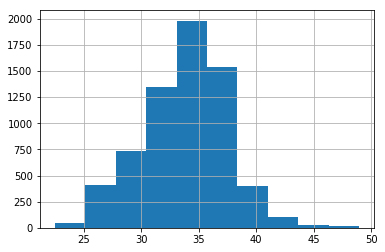

In [686]:
pd.DataFrame({'x': predictions})['x'].hist()

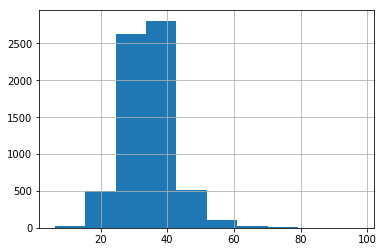

In [669]:
pd.DataFrame({'x': targets})['x'].hist()

In [689]:
pd.DataFrame({'x': (targets - predictions).apply (lambda x: abs(x))})['x'].describe()

count   6611.0
mean       4.7
std        4.6
min        0.0
25%        1.7
50%        3.5
75%        6.4
max       61.7
Name: x, dtype: float64

In [358]:
pd.DataFrame({'x': (targets - 34.4).apply (lambda x: abs(x))})['x'].describe()

ValueError: If using all scalar values, you must pass an index

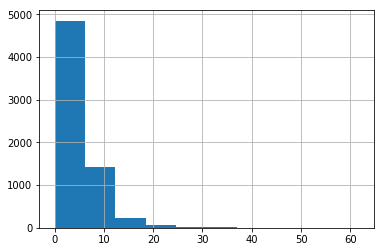

In [691]:
pd.DataFrame({'x': (targets - predictions).apply (lambda x: abs(x))})['x'].hist()

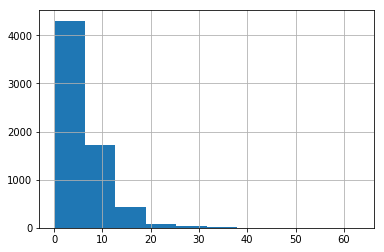

In [692]:
pd.DataFrame({'x': (targets - 34.4).apply (lambda x: abs(x))})['x'].hist()